In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy
import time
import seaborn as sns
import pickle as pkl
from operator import itemgetter

In [2]:
metro = pd.read_csv("data/dataset_train.csv")
metro["timestamp"] = pd.to_datetime(metro["timestamp"],dayfirst=True)
metro["timestamp_day"] = metro.timestamp - np.timedelta64(2,"h")-np.timedelta64(1,"s")

In [3]:
air_leak1_dates = {"start": pd.to_datetime("28-02-2022 21:53:00",
                                           dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                   "end":pd.to_datetime("01-03-2022 02:00:00",
                                        dayfirst=True)- pd.offsets.DateOffset(hours=2,seconds=1)}
air_leak2_dates = {"start": pd.to_datetime("23-03-2022 14:54:00",
                                           dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                   "end":pd.to_datetime("23-03-2022 15:24:00",
                                        dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1)}
oil_leak_dates = {"start": pd.to_datetime("30-05-2022 12:00:00",
                                          dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                  "end":pd.to_datetime("02-06-2022 06:18:00",
                                       dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1)}

In [4]:
air_leak1 = metro.loc[(metro.timestamp_day >= air_leak1_dates["start"]) &
                      (metro.timestamp_day < air_leak1_dates["end"]),:]
air_leak2 = metro.loc[(metro.timestamp_day >= air_leak2_dates["start"]) &
                      (metro.timestamp_day < air_leak2_dates["end"]),:]
oil_leak = metro.loc[(metro.timestamp_day >= oil_leak_dates["start"]) &
                     (metro.timestamp_day < oil_leak_dates["end"]),:]

In [5]:
def test_and_train_val_dates():
    init_train_s = metro.timestamp_day[0]
    init_train_e = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1) - pd.offsets.DateOffset(days=2)
    init_val_s = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1) - pd.offsets.DateOffset(days=2)
    init_val_e = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1)
    init_test_s = init_val_e
    init_test_e = init_test_s + pd.offsets.DateOffset(weeks=1)

    train_dates = [[init_train_s,init_train_e]]
    test_dates = [[init_test_s,init_test_e]]
    val_dates = [[init_val_s, init_val_e]]

    last_date = metro.timestamp_day.iloc[-1]
    prev_test_end = init_test_e
    while prev_test_end < last_date:
        new_test_end = prev_test_end + pd.offsets.DateOffset(weeks=1)
        new_train_start = prev_test_end - pd.offsets.DateOffset(months=1)
        new_val_start = prev_test_end - pd.offsets.DateOffset(days=2)
        train_dates.append([new_train_start,new_val_start])
        val_dates.append([new_val_start, prev_test_end])
        test_dates.append([prev_test_end,new_test_end])
        prev_test_end = new_test_end
    return train_dates, val_dates, test_dates

In [6]:
train_dates, val_dates, test_dates = test_and_train_val_dates()

In [7]:
def generate_cycles(df):
    comp_change = list((t:=metro.COMP.diff().eq(0))[t==False].index[1:]) # if all changes to separate
    #filling up and spending
    #comp_change = list((t:=df.COMP.diff().eq(-1))[t==True].index)
    return [[comp_change[i],comp_change[i+1]] for i in range(len(comp_change)-1)]

In [8]:
all_cycles = generate_cycles(metro)

In [62]:
all_cycles_comp0 = [cycle for i, cycle in enumerate(all_cycles) if i%2 == 0][:-1]
all_cycles_comp1 = [cycle for i, cycle in enumerate(all_cycles) if i%2 == 1]

In [66]:
comp0_cycle_lengths = list(map(lambda x: (x[1] - x[0]), all_cycles_comp0))
comp1_cycle_lengths = list(map(lambda x: (x[1] - x[0]), all_cycles_comp1))

In [76]:
sorted(comp0_cycle_lengths)

[1,
 1,
 1,
 1,
 2,
 2,
 3,
 4,
 4,
 4,
 5,
 7,
 10,
 11,
 11,
 12,
 12,
 14,
 15,
 16,
 16,
 17,
 17,
 18,
 19,
 20,
 20,
 20,
 21,
 22,
 23,
 24,
 24,
 25,
 25,
 26,
 27,
 27,
 28,
 29,
 29,
 30,
 30,
 32,
 32,
 33,
 34,
 35,
 35,
 36,
 36,
 36,
 38,
 40,
 41,
 41,
 44,
 45,
 46,
 47,
 48,
 48,
 49,
 50,
 51,
 52,
 52,
 52,
 53,
 54,
 54,
 54,
 55,
 55,
 56,
 57,
 60,
 61,
 61,
 62,
 63,
 63,
 64,
 64,
 65,
 66,
 67,
 67,
 67,
 68,
 69,
 69,
 69,
 69,
 70,
 70,
 70,
 71,
 72,
 72,
 73,
 73,
 73,
 74,
 75,
 75,
 76,
 76,
 76,
 76,
 78,
 78,
 79,
 80,
 80,
 80,
 80,
 81,
 81,
 82,
 82,
 84,
 84,
 85,
 86,
 87,
 88,
 88,
 88,
 89,
 89,
 91,
 91,
 92,
 92,
 92,
 92,
 92,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 93,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 9

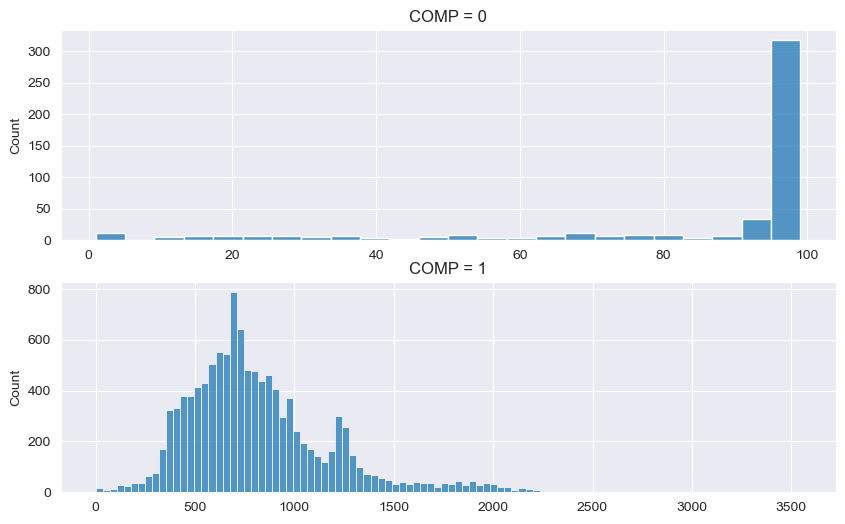

In [75]:
fig, axes = plt.subplots(2,1, figsize=(10,6))

sns.histplot([l for l in comp0_cycle_lengths if l<100], ax = axes[0])
axes[0].set_title("COMP = 0")

sns.histplot(comp1_cycle_lengths, ax = axes[1])
axes[1].set_title("COMP = 1")

plt.show()

In [12]:
def match_cycles_to_dates(cycle):
    cycle_start, cycle_end = cycle
    cycle_start_date = metro.iloc[cycle_start, :].timestamp_day
    cycle_end_date = metro.iloc[cycle_end, :].timestamp_day
    return [cycle_start_date, cycle_end_date]

In [13]:
def test_val_train_cycles(cycle_dates, train_dates, val_dates, test_dates):
    train_inds, val_inds, test_inds = [], [], []
    for j in range(len(train_dates)):
        t_start, t_end = train_dates[j]
        val_start, val_end = val_dates[j]
        test_s, test_e = test_dates[j]
        i=0
        while cycle_dates[i][0] < t_start:
            i+=1
        train_start_ind = i
        while cycle_dates[i][0] < t_end:
            i+=1
        train_end_ind = i
        val_start_ind = train_end_ind
        while cycle_dates[i][0] < val_end:
            i+=1
        val_end_ind = i
        test_start_ind = val_end_ind
        while i < len(cycle_dates) and cycle_dates[i][0] < test_e:
            i+=1
        test_end_ind = i

        train_inds.append([train_start_ind, train_end_ind])
        val_inds.append([val_start_ind, val_end_ind])
        test_inds.append([test_start_ind, test_end_ind])

    return train_inds, val_inds, test_inds

In [14]:
analog_sensors = ["TP2", "TP3", "H1","DV_pressure", "Reservoirs", "Oil_temperature", "Flowmeter", "Motor_current"]
digital_sensors = ["COMP", "DV_electric", "Towers", "MPG", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses"]
all_sensors = analog_sensors + digital_sensors

In [72]:
with open(f"data/online_train_val_test_inds.pkl", "rb") as indspkl:
    train_inds, val_inds, test_inds = pkl.load(indspkl)

In [20]:
def generate_cycle_tensors(df, cycle_inds, cols):
    scaler = StandardScaler()
    tensor_list = []
    for i_s, i_f in cycle_inds:
        df_slice = df.iloc[i_s:i_f,:]
        df_slice = df_slice.loc[:,cols]
        df_slice[df_slice.columns] = scaler.fit_transform(df_slice[df_slice.columns])
        tensor_chunk = th.tensor(df_slice.values).unsqueeze(0).float()
        tensor_list.append(tensor_chunk)
    return tensor_list

In [21]:
all_tensors_comp0 = generate_cycle_tensors(metro, all_cycles_comp0, analog_sensors)
all_tensors_comp1 = generate_cycle_tensors(metro, all_cycles_comp1, analog_sensors)

In [22]:
def yield_tensors_full(list_of_cycles, cycle_inds):
    first_cycle, last_cycle = cycle_inds
    tensor_list = []
    for cycle in range(first_cycle, last_cycle):
        tensor_list.append(list_of_cycles[cycle])
    return tensor_list

In [74]:
for loop in range(len(train_inds)):
    train_tensors_comp0 = yield_tensors_full(all_tensors_comp0, train_inds[loop])
    train_tensors_comp1 = yield_tensors_full(all_tensors_comp1, train_inds[loop])
    val_tensors_comp0 = yield_tensors_full(all_tensors_comp0, val_inds[loop])
    val_tensors_comp1 = yield_tensors_full(all_tensors_comp1, val_inds[loop])
    test_tensors_comp0 = yield_tensors_full(all_tensors_comp0, test_inds[loop])
    test_tensors_comp1 = yield_tensors_full(all_tensors_comp1, test_inds[loop])
    with open(f"data/train_tensors_comp0_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(train_tensors_comp0,tensorpkl)
    with open(f"data/train_tensors_comp1_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(train_tensors_comp1,tensorpkl)
    with open(f"data/val_tensors_comp0_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(val_tensors_comp0,tensorpkl)
    with open(f"data/val_tensors_comp1_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(val_tensors_comp1,tensorpkl)
    with open(f"data/test_tensors_comp0_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(test_tensors_comp0,tensorpkl)
    with open(f"data/test_tensors_comp1_{loop}_analog_feats.pkl","wb") as tensorpkl:
        pkl.dump(test_tensors_comp1,tensorpkl)

In [81]:
for loop in range(len(train_inds)):
    train_tensors_comp0 = yield_tensors_full(all_tensors_comp0, train_inds[loop])
    for tensor in train_tensors_comp0:
        if len(tensor.shape) < 3:
            print(tensor,loop,"train comp0")
    train_tensors_comp1 = yield_tensors_full(all_tensors_comp1, train_inds[loop])
    for tensor in train_tensors_comp1:
        if len(tensor.shape) < 3:
            print(tensor,loop,"train comp1")
    val_tensors_comp0 = yield_tensors_full(all_tensors_comp0, val_inds[loop])
    for tensor in val_tensors_comp0:
        if len(tensor.shape) < 3:
            print(tensor,loop,"val comp0")
    val_tensors_comp1 = yield_tensors_full(all_tensors_comp1, val_inds[loop])
    for tensor in train_tensors_comp1:
        if len(tensor.shape) < 3:
            print(tensor,loop,"val comp1")
    test_tensors_comp0 = yield_tensors_full(all_tensors_comp0, test_inds[loop])
    for tensor in test_tensors_comp0:
        if len(tensor.shape) < 3:
            print(tensor,loop,"test comp0")
    test_tensors_comp1 = yield_tensors_full(all_tensors_comp1, test_inds[loop])
    for tensor in test_tensors_comp1:
        if len(tensor.shape)<3:
            print(tensor,loop,"test comp1")

In [80]:
test_tensors_comp1[0].shape

torch.Size([1, 967, 8])